In [1]:
%load_ext autoreload
%autoreload 2
%env TFHUB_CACHE_DIR=tfhub/

env: TFHUB_CACHE_DIR=tfhub/


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt

In [4]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch
from tqdm import tqdm

from src.bpe_summarizer import bpe_summarize, sentencizer
from validation import scicummnet_validation, similarity_score, mean_rouge_fscore

INFO:absl:Using tfhub/ to cache modules.


In [5]:
validation_set = scicummnet_validation("../validation/data/scisummnet_release1.1__20190413/")

In [6]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [37]:
sample_text, human_summary = random_sample
human_summary

'A Bayesian Hybrid Method For Context-Sensitive Spelling Correction\nTwo classes of methods have been shown to be useful for resolving lexical ambiguity.\nThe first relies on the presence of particular words within some distance of the ambiguous target word; the second uses the pattern of words and part-of-speech tags around the target word.\nThese methods have complementary coverage: the former captures the lexical "atmosphere" (discourse topic, tense, etc.), while the latter captures local syntax.\nYarowsky has exploited this complementarity by combining the two methods using decision lists.\nThe idea is to pool the evidence provided by the component methods, and to then solve a target problem by applying the single strongest piece of evidence, whatever type it happens to be.\nThis paper takes Yarowsky\'s work as a starting point, applying decision lists to the problem of context-sensitive spelling correction.\nDecision lists are found, by and large, to outperform either component me

In [41]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=50)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

"A Bayesian Hybrid Method For Context-Sensitive Spelling CorrectionTwo classes of methods have been shown to be useful for resolving lexical ambiguity. The first relies on the presence of particular words within some distance of the ambiguous target word; the second uses the pattern of words and part-of-speech tags around the target word. These methods have complementary coverage: the former captures the lexical &amp;quot;atmosphere&amp;quot; (discourse topic, tense, etc. ), while the latter captures local syntax. Yarowsky has exploited this complementarity by combining the two methods using decision lists. The idea is to pool the evidence provided by the component methods, and to then solve a target problem by applying the single strongest piece of evidence, whatever type it happens to be. This paper takes Yarowsky's work as a starting point, applying decision lists to the problem of context-sensitive spelling correction. Decision lists are found, by and large, to outper"

In [42]:
mean_rouge_fscore(bpe_summary, human_summary)

0.8077994380509153

In [43]:
similarity_score(bpe_summary, human_summary)

-0.7109375

In [44]:
from transformers import BartTokenizer

# stripped down pipeline to only summarization task
# https://github.com/huggingface/transformers/blob/70bc3ead4f0b08e8cadd1805ada2a22f0c302399/src/transformers/pipelines.py#L1476

def bart_summarizer(text):
    bart_tokenizer: BartTokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    bart_tokens = bart_tokenizer.encode(text)
    return bart_tokenizer.decode(bart_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True,)

In [45]:
bart_summary = bart_summarizer(sample_text[:1024])
bart_summary

"\n  A Bayesian Hybrid Method For Context-Sensitive Spelling Correction\n  \n    Two classes of methods have been shown to be useful for resolving lexical ambiguity.\n    The first relies on the presence of particular words within some distance of the ambiguous target word; the second uses the pattern of words and part-of-speech tags around the target word.\n    These methods have complementary coverage: the former captures the lexical &amp;quot;atmosphere&amp;quot; (discourse topic, tense, etc.\n    ), while the latter captures local syntax.\n    Yarowsky has exploited this complementarity by combining the two methods using decision lists.\n    The idea is to pool the evidence provided by the component methods, and to then solve a target problem by applying the single strongest piece of evidence, whatever type it happens to be.\n    This paper takes Yarowsky's work as a starting point, applying decision lists to the problem of context-sensitive spelling correction.\n    Decision lists

In [46]:
mean_rouge_fscore(bart_summary, human_summary)

0.8166666618149692

In [47]:
similarity_score(bart_summary, human_summary)

-0.7421875

In [48]:
sample_size = 100

In [49]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bart_summary = bart_summarizer(sample_text[:1024])
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary, human_summary))

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


In [50]:
np.mean(bart_scores)

-0.6517462

In [51]:
# TODO: abstract
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 120.14it/s]


In [52]:
np.mean(bpe_scores)

-0.6508421

(0.0, -1.0)

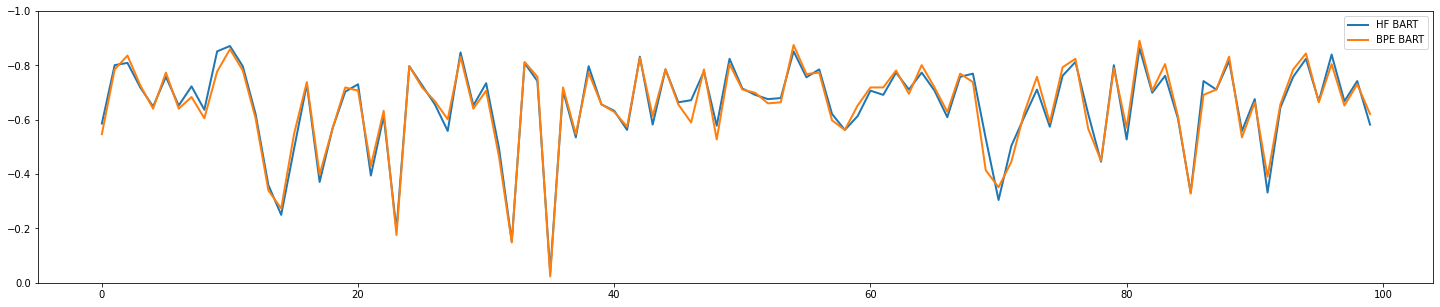

In [53]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE BART')
ax.legend()

plt.ylim(0,-1)

In [54]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.890625


'Lexical Semantic Techniques For Corpus Analysis\nIn this paper we outline a research program for computational linguistics, making extensive use of text corpora.\nWe demonstrate how a semantic framework for lexical knowledge can suggest richer relationships among words in text beyond that of simple co-occurrence.\nThe work suggests how linguistic phenomena such as metonymy and polysemy might be exploitable for semantic tagging of lexical items.\nUnlike with purely statistical collocational analyses, the framework of a semantic theory allows the automatic construction of predictions about deeper semantic relationships among words appearing in collocational systems.\nWe illustrate the approach for the acquisition of lexical information for several classes of nominals, and how such techniques can fine-tune the lexical structures acquired from an initial seeding of a machine-readable dictionary.\nIn addition to conventional lexical semantic relations, we show how information concerning le

In [55]:
bpe_summaries[best]

'Lexical Semantic Techniques For Corpus AnalysisIn this paper we outline a research program for computational linguistics, making extensive use of text corpora. We demonstrate how a semantic framework for lexical knowledge can suggest richer relationships among words in text beyond that of simple co-occurrence. The work suggests how linguistic phenomena such as metonymy and polysemy might be exploitable for semantic tagging of lexical items. Unlike with purely statistical collocational analyses, the framework of a semantic theory allows the automatic construction of predictions about deeper semantic among words appearing in systems. illustrate the approach for the acquisition of lexical information for several classes of nominals, and how such techniques can fine-tune the lexical structures acquired from an initial seeding of a machine-readable dictionary. In addition to conventional lexical semantic relations, we show how information concerning lexical presuppositions and preference'

In [56]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.87109375


'Mildly Non-Projective Dependency Structures\nSyntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\nIn dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\nWhile projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\nIn this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\nThe results indicate that a combination of the well-nestedness constraint and a parametric con

In [57]:
bart_summaries[best]

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [58]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [59]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bpe_summarize(blob)
result

'The most meaningful part of this sentence is here.'

In [60]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bart_summarizer(blob)
result

' The most meaningful part of this sentence is here. I frost apples. Kung fu.'

In [61]:
from transformers import GPT2Tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_bpe_scores = []
gpt2_bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70, tokenizer=gpt2_tokenizer)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    gpt2_bpe_summaries.append(bpe_summary)
    gpt2_bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 118.22it/s]


In [62]:
print("GPT2 Vocab Best:", np.min(gpt2_bpe_scores))
print("GPT2 Vocab Mean:", np.mean(gpt2_bpe_scores))

GPT2 Vocab Best: -0.890625
GPT2 Vocab Mean: -0.6506077


(0.0, -1.0)

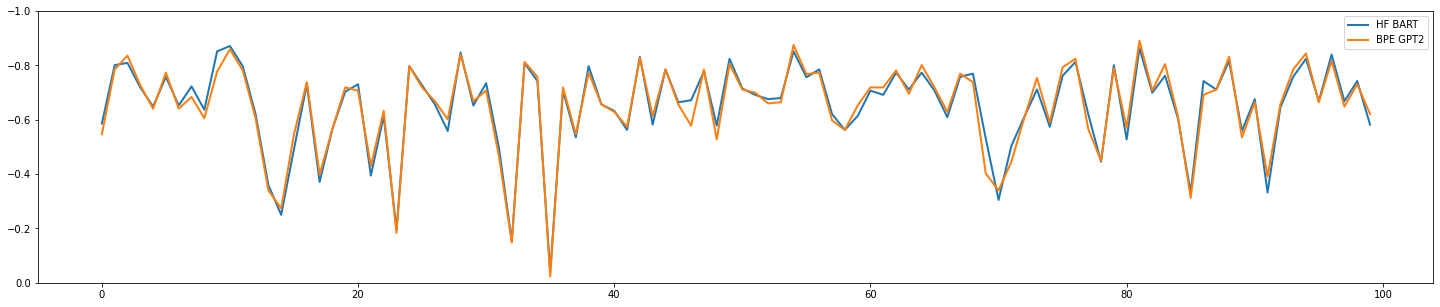

In [63]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(gpt2_bpe_scores), linewidth=2, label='BPE GPT2')
ax.legend()

plt.ylim(0,-1)

In [64]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
distilbert_bpe_scores = []
distilbert_bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70, tokenizer=distilbert_tokenizer)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    distilbert_bpe_summaries.append(bpe_summary)
    distilbert_bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 110.16it/s]


In [65]:
print("DistilBert Vocab Best:", np.min(distilbert_bpe_scores))
print("DistilBert Vocab Mean:", np.mean(distilbert_bpe_scores))

DistilBert Vocab Best: -0.890625
DistilBert Vocab Mean: -0.65459204


(0.0, -1.0)

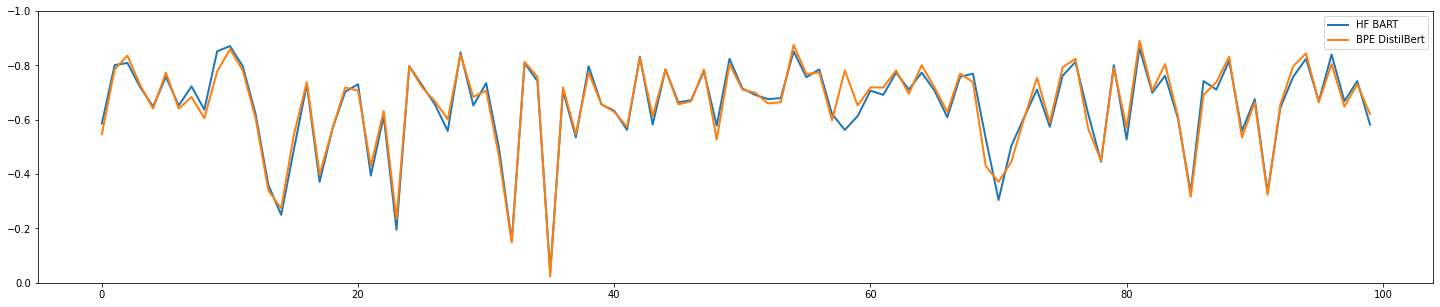

In [66]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(distilbert_bpe_scores), linewidth=2, label='BPE DistilBert')
ax.legend()

plt.ylim(0,-1)